In [1]:
#%% make parent tree graph
from treelib import Tree
import numpy as np
import os 
import pandas as pd
import requests

path = '/nfs/z1/userhome/ZhouMing/workingdir/Video/HACS/stimulus_select/hierarchy'
taxonomy = pd.read_csv(f'{path}/taxonomy_raw.csv')
tree = Tree()

# prepare selected classes
action_dataset_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/exp/video'
class_selected = os.listdir(action_dataset_path)
class_all = pd.read_csv(f'{path}/taxonomy.csv')['nodeName'].tolist()
class_remove = list(set(class_all).difference(set(class_selected)))

remain_node = {'nodeName':[], 'nodeId':[], 'parentId':[]}
remove_id = []

for row in range(taxonomy.shape[0]):
    nodeName, nodeId, parentId = taxonomy.loc[row, ['nodeName', 'nodeId', 'parentId']]
    if not np.isnan(parentId):
        parentId = int(parentId)
    else:
        parentId = None
    # record remove ids
    if nodeName in class_remove:
        remove_id.append(nodeId)
    # adding node into tree
    try:
        tree.create_node(tag=nodeName, identifier=nodeId, parent=parentId)
    except:
        # if parentId is not defined, then add it into dict
        remain_node['nodeName'].append(nodeName)
        remain_node['nodeId'].append(nodeId)
        remain_node['parentId'].append(parentId)
        continue

# Add undefined parentId into tree
for idx in range(len(remain_node['nodeName'])):
    nodeName = remain_node['nodeName'][idx]
    nodeId = remain_node['nodeId'][idx]
    parentId = remain_node['parentId'][idx]
    tree.create_node(tag=nodeName, identifier=nodeId, parent=parentId)

# Remove unwanted classes
for idx in remove_id:
    tree.remove_node(idx)


In [2]:
def lca(nodes):
    """Returns the Least Common Ancestor (LCA) of a list of nodes"""
    
    if len(nodes) == 1:
        return nodes[0]
    elif len(nodes) > 2:
        return lca([lca(nodes[:2])] + nodes[2:])
    elif len(nodes) == 2:
        node1, node2 = nodes
        set1 = set([node1])
        set2 = set([node2])
        
        while True:
            if node1 in set2:
                return node1
            if node2 in set1:
                return node2
            if tree.parent(node1.identifier) != None:
                node1 = tree.parent(node1.identifier)
            if tree.parent(node2.identifier) != None:
                node2 = tree.parent(node2.identifier)
            
            set1.add(node1)
            set2.add(node2)
    else:
        raise Exception("No nodes given")


In [6]:
# compute similarity matrix in this part
parent_names = ['Eating and drinking Activities', 'Household Activities', 'Personal Care',
               'Socializing, Relaxing, and Leisure', 'Sports, Exercise, and Recreation']

class_order = []
superclass_order = []
for parent_idx, parent_name in enumerate(parent_names):
    sub_tree = tree.subtree(taxonomy.loc[taxonomy.nodeName==parent_name, 'nodeId'].values[0])
    sub_tree_leaves =  [node.tag for node in sub_tree.leaves() if node.tag in class_selected]
    sub_tree_leaves.sort()
    class_order.extend(sub_tree_leaves)
    superclass_order.extend(np.repeat(parent_idx, len(sub_tree_leaves)))

sim_matrix = np.zeros((180, 180))
for base_idx, base_class in enumerate(class_order):
    for target_idx, target_class in enumerate(class_order):
        # get Least Common Ancestor (LCA) of a list of nodes
        node_base = taxonomy.loc[taxonomy.nodeName==base_class, 'nodeId'].values[0]
        node_target = taxonomy.loc[taxonomy.nodeName==target_class, 'nodeId'].values[0]
        node_lca = lca([tree.get_node(node_base), tree.get_node(node_target)])
        depth_lca = tree.depth(node_lca)
        # compute Wu & Palmer Similarity 
        depth_base, depth_target = tree.depth(tree.get_node(node_base)), tree.depth(tree.get_node(node_target))
        sim = 2 * (depth_lca+1) / (depth_base + depth_target + 2)
        sim_matrix[base_idx, target_idx] = sim
        print(f'Finish base:{base_class}')


Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
Finish base:Baking cookies
F

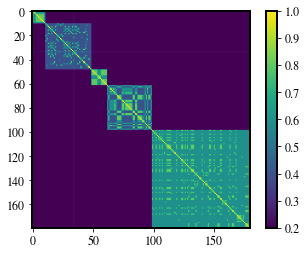

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

plt.imshow(sim_matrix)
plt.colorbar()
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/data_paper/result'
np.save(pjoin(result_path, 'activity_net_sim.npy'), sim_matrix)
np.save(pjoin(result_path, 'class_order.npy'), np.array(class_order))
np.save(pjoin(result_path, 'superclass_order.npy'), np.array(superclass_order))
